In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [78]:
data = pd.read_csv('/Users/alikhansainov/Desktop/Karpov/processed_train copy 2.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [79]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler


### Your code is here
pipe_lr = Pipeline([
    ('StandardScaler', MinMaxScaler()),
    ('LogisticRegression', LogisticRegression())
])
pipe_svm = Pipeline([
    ('StandardScaler', MinMaxScaler()),
    ('LinearSVC', LinearSVC())
])
pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)

print (pipe_lr.best_params_) # C-0.01, penalty = l2

AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [ ]:
### Обучаем модели на трейне
### Your code is here
from sklearn.metrics import accuracy_score
predictions_lr = pipe_lr.predict(X_test)
predictions_svm = pipe_svm.predict(X_test)
accuracy_lr = accuracy_score(y_test, predictions_lr)
accuracy_svm = accuracy_score(y_test, predictions_svm)
print(accuracy_lr)
print(accuracy_svm)


0.8424409153432537
0.84039848276437


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [ ]:
def p_y1x(vector):
    min = np.min(vector)
    max = np.max(vector)

    p = []
    for i in vector:
        if i == min:
            p.append(0)
        elif i==max:
            p.append(1)
        elif i < 0:            
            p.append(np.abs(i - min) / np.abs(min) * 0.5)
        else:
            p.append(np.abs(i) / np.abs(max) * 0.5 + 0.5)
    
    return p

In [ ]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
predict_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, predict_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)
print(f"AUC для логистической регрессии: {auc_lr:.3f}")


AUC для логистической регрессии: 0.689


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AUC SVM: 0.688


,decision_function,predict_proba
0,-0.553900,0.342680
1,-0.671429,0.309300
2,-0.745601,0.288233
3,-0.617369,0.324654
4,-0.827186,0.265061
...,...,...
23986,-0.850042,0.258570
23987,-0.831227,0.263914
23988,-0.766933,0.282174
23989,-0.600680,0.329394


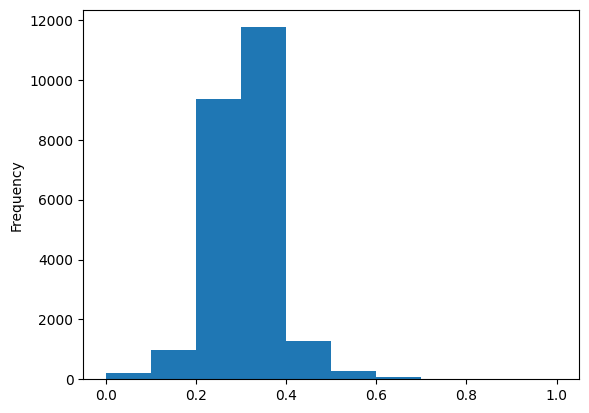

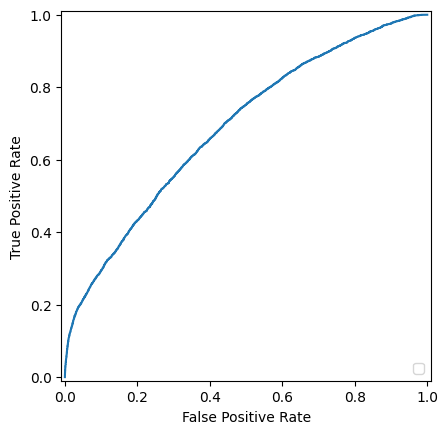

In [ ]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here


decision_function = pipe_svm.decision_function(X_test)
predict_proba_svm = p_y1x(decision_function)

df = pd.DataFrame([decision_function, predict_proba_svm]).T
df.columns = ['decision_function', 'predict_proba']
df.predict_proba.plot(kind='hist', bins=10);

fpr, tpr, thresholds = roc_curve(y_test, predict_proba_svm)

auc_svm = auc(fpr, tpr)
print(f'AUC SVM: {auc_svm:.3f}')

RocCurveDisplay(fpr=fpr, tpr=tpr).plot();
df
# auc_svm = auc()

In [ ]:
from sklearn.metrics import auc 

### Your code is here




Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

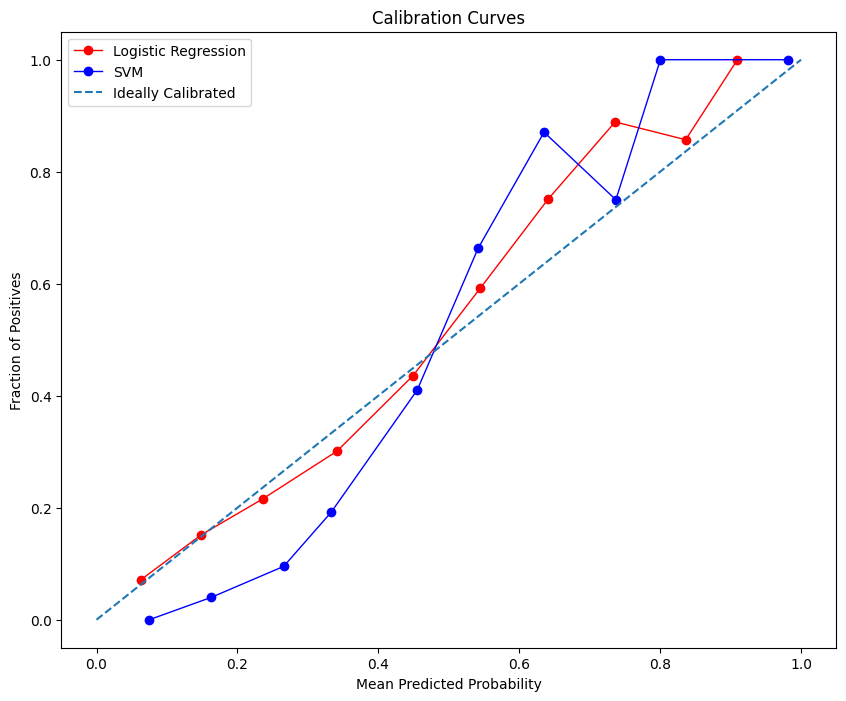

0.043627467846722744
0.04617390479289701


In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error

### Your code is here
prob_true_lr, prob_pred_lr = calibration_curve(y_test, predict_proba_lr, n_bins=10)
prob_true_svm, prob_pred_svm = calibration_curve(y_test, predict_proba_svm, n_bins=10)

plt.figure(figsize=(10, 8))

plt.plot(prob_pred_lr, prob_true_lr, marker='o', linewidth=1, label='Logistic Regression', color='red')
plt.plot(prob_pred_svm, prob_true_svm, marker='o', linewidth=1, label='SVM', color='blue')
ideal = np.linspace(0, 1, 10)
rmse_lr = np.sqrt(mean_squared_error(ideal, prob_pred_lr))
rmse_svm = np.sqrt(mean_squared_error(ideal, prob_pred_svm))


plt.plot([0, 1], [0, 1], linestyle='--', label='Ideally Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves')
plt.legend()

plt.show()
print (rmse_lr)
print (rmse_svm)

In [ ]:


### Your code is here




**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [ ]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here


calibration_sigmoid = CalibratedClassifierCV(pipe_svm,cv=5,method='sigmoid')
calibration_sigmoid.fit(X_train, y_train)
calibrated_probs = calibration_sigmoid.predict_proba(X_test)[:,1]


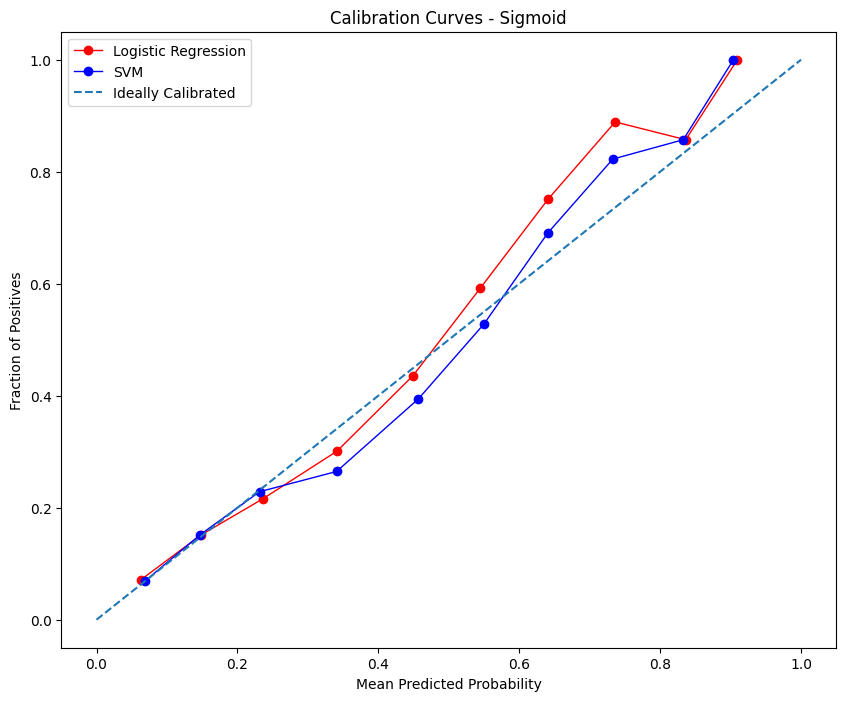

0.043627467846722744
0.0463110786766564


In [ ]:
### Новая кривая

### Your code is here

calibrated_probs
prob_true_svm, prob_pred_svm = calibration_curve(y_test, calibrated_probs, n_bins=10)
plt.figure(figsize=(10, 8))
plt.plot(prob_pred_lr, prob_true_lr, marker='o', linewidth=1, label='Logistic Regression', color='red')
plt.plot(prob_pred_svm, prob_true_svm, marker='o', linewidth=1, label='SVM', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideally Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves - Sigmoid')
plt.legend()

plt.show()
ideal = np.linspace(0, 1, 10)
rmse_lr = np.sqrt(mean_squared_error(ideal, prob_pred_lr))
rmse_svm = np.sqrt(mean_squared_error(ideal, prob_pred_svm))
print (rmse_lr)
print (rmse_svm)

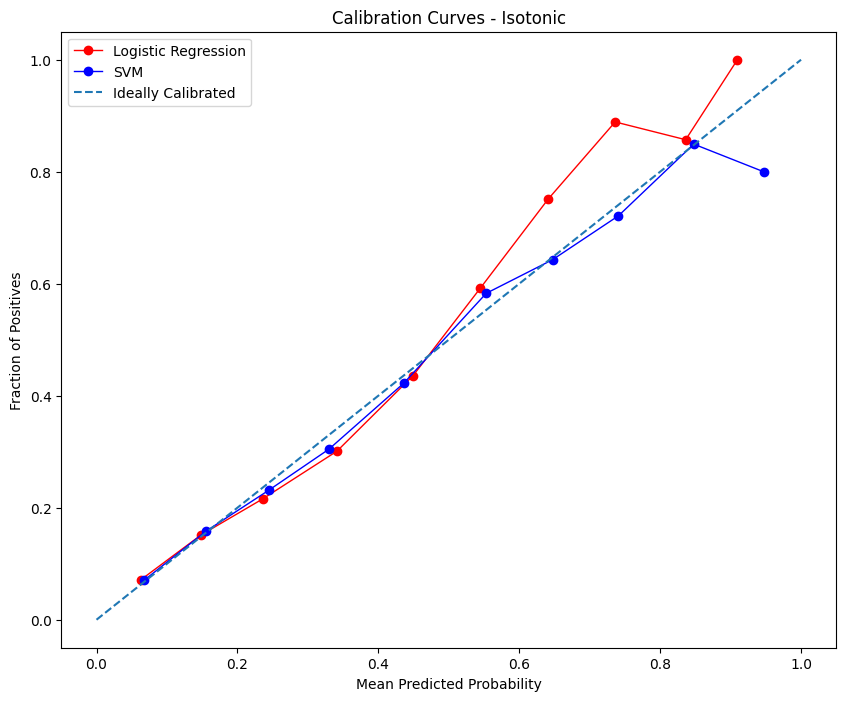

In [ ]:

from sklearn.metrics import brier_score_loss
calibration_isotonic = CalibratedClassifierCV(pipe_svm,cv=5,method='isotonic')
calibration_isotonic.fit(X_train, y_train)
calibrated_probs = calibration_isotonic.predict_proba(X_test)[:,1]

calibrated_probs
prob_true_svm, prob_pred_svm = calibration_curve(y_test, calibrated_probs, n_bins=10)
plt.figure(figsize=(10, 8))
plt.plot(prob_pred_lr, prob_true_lr, marker='o', linewidth=1, label='Logistic Regression', color='red')
plt.plot(prob_pred_svm, prob_true_svm, marker='o', linewidth=1, label='SVM', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideally Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves - Isotonic')
plt.legend()

plt.show()
